# Agrupamiento de documentos

Autor: Eric S. Tellez <eric.tellez@infotec.mx> <br/>


## Introducción

Hasta el momento hemos visto operaciones de búsqueda de texto completo y de la búsqueda en espacios métricos.
Ambas operaciones son fundamentales en un sistema de recuperación de información, y de hecho, en otras áreas como son la inteligencia computacional. También se vio la clasificación basada en vecinos cercanos como una herramienta para comparar modelos de texto.

Recordemos que el objetivo de la disciplina de Recuperación de Información es facilitar el acceso a las personas a grandes cúmulos de información, de tal forma que seamos capaces de encontrar la información sobre la que se realizan consultas. En ese espíritu, el agrupamiento (clustering) y la visualización son de gran ayuda para obtener información de valor.

En el agrupamiento se parte una base de datos métrica (documentos o cualquier otro tipo de dato) de tal forma que los elementos en cada una de sus partes tengan cierta afinidad, por ejemplo que sean cercanos y compactos, o que pertenezcan a un grupo donde la densidad sea alta. Normalmente se intenta reducir una función de costo para cada grupo y de manera global.

Recuerde que en la representación basada en bolsas de palabras es común encontrar vectores de decenas o cientos de miles de dimensiones, aunque sumamente dispersos. En las representaciones semánticas se encuentran en espacios densos de cientos de dimensiones. La distancia en ambos casos es comúnmente medida en términos de los ángulos de los vectores, ya que esto nos permité disociar las magnitudes que cambiarán con la cantidad de componentes y con el tamaño de los documentos. Lo último nos da ventajas ya que normalmente se desea recuperar documentos largos a partir de consultas pequeñas. Sin embargo, para tareas como clustering de documentos, dichos supuestos son incorrectos, ya que los vectores son los mismos documentos de un corpus. Esto hace que algunos de los supuestos sobre el funcionamiento de algunos índices sean imprecisos, en particular, el índice invertido no tiene su gran ventaja que sería acceder a unas pocas listas de posteo y el costo sería mucho más elevado que resolver consultas de usuarios.

## Agrupamiento (clustering)

Existen diversos algoritmos de clustering que pueden apoyar en la tarea, todos ellos con diferentes características que lo hacen adecuado para ciertas tareas. En particular, podemos mencionar algunos ejemplos paradigmáticos, como sigue:

- [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering): Intenta encontrar los $k$ centros $C$ que minimicen la suma de las distancias al cuadrado de todos los elementos de la base de datos a algún elemento en $C$. En su forma más simple, el algoritmo comienza con una muestra aleatoria de $k$ puntos y usa el [algoritmo de Lloyd](https://en.wikipedia.org/wiki/Lloyd%27s_algorithm) para refinar los $k$ puntos: en cada iteración, se genera una partición con los elementos más cercanos a cada uno de los centroides, y se usan para generar nuevos centroides. El algoritmo convergerá en algunas iteraciones ya que es bastante rápido. Tiene como desventaja que el usuario debe saber el número de grupos $k$ óptimo y que su calidad puede variar de manera dramática con diferentes formas de inicializar el algoritmo.

- [affinity propagation](https://en.wikipedia.org/wiki/Affinity_propagation): Usa tres matrices y un esquema basado en mensajes para obtener los elementos más adecuados para representar una base de datos. En este algoritmo no es necesario especificar $k$ ya que se calcula como parte del proceso. Las tres matrices son, la matriz de similitud, la matriz de reponsabilidad y de de disponibilidad. La idea es considerar a todos los elementos como posibles centros e intercambiar mensajes entre las matrices de responsabilidad y disponibilidad, usando la matriz de similitud como base de la información. El algoritmo es iterativo y se detendrá cuando no haya cambios en las matrices o se llegue a un límite en el número de las iteraciones. La estructura del cluster emergerá como parte este proceso.

- [DBSCAN](https://es.wikipedia.org/wiki/DBSCAN): Es un algoritmo que es especial para descubrir grupos en base a la densidad, de tal forma que para que dos puntos $u$ y $v$ pertenezcan al mismo grupo, no necesariamente son cercanos entre ellos, pero si que hay una serie de puntos $\{w_i\}$ en el mismo grupo con los que se puede trazar una ruta entre $u$ y $v$. Ahora, para que un elemento forme parte de un grupo debe cumplir que comparte al menos $\ell$ elementos en común con el grupo en un radio de búsqueda $\epsilon$, los puntos dentro de una ruta entonces cumplen con estas propiedades. A diferencia de los algoritmos basados en particiones compactas, las formas de los grupos en DBSCAN pueden ser caprichosas. No es necesario conocer el número de centros pero si $\ell$ y $\epsilon$.


In [1]:
using Pkg
Pkg.activate(".")

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, 
    StatsBase, Clustering, Plots, LinearAlgebra, HypertextLiteral, JLD2, JSON, DataFrames

  Activating project at `~/Cursos/IR-2024/Unidades`


In [2]:
function create_index(db)
    dist = NormalizedCosineDistance()
    #db = VectorDatabase(vectors)
    index = SearchGraph(; dist, db)
    index!(index)
    optimize_index!(index, MinRecall(0.9))
    index
end


create_index (generic function with 1 method)

In [3]:
include("read_datasets.jl")

E = let
    corpus, _ = read_news()
    Xtrain = load("data/spanish-twitter-news-and-opinions-top25-68.train--sbert-multi-L12-v2.h5", "emb")::Matrix{Float32}
    index = create_index(MatrixDatabase(Xtrain))
    (; corpus, index)
end

nothing

# Reducción de dimensión

In [4]:
function create_umap_embeddings(index; k=15, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
    # layout = RandomLayout()
    # increase both `n_epochs` and `neg_sample_rate` to improve projection
    # layout = SpectralLayout() ## the results are much better with Spectral layout
    U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
    U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
    (e2=U2.embedding, e3=U3.embedding)
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
end

plot_umap (generic function with 1 method)

In [5]:
@info Threads.nthreads()
@time e2, e3 = create_umap_embeddings(E.index, k=15, tol=1e-4, layout=RandomLayout());

[ Info: 64


  0.550055 seconds (243.87 k allocations: 16.921 MiB, 57.73% compilation time)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.255180318
- embedding init: 0.000330209
- embedding opt: 3.626584851



 17.996525 seconds (9.46 M allocations: 674.086 MiB, 1.27% gc time, 46.09% compilation time)


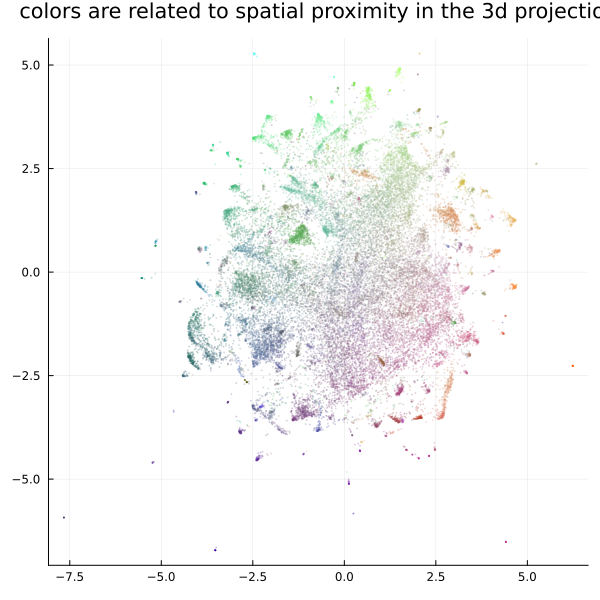

In [6]:
plot_umap(e2, e3)

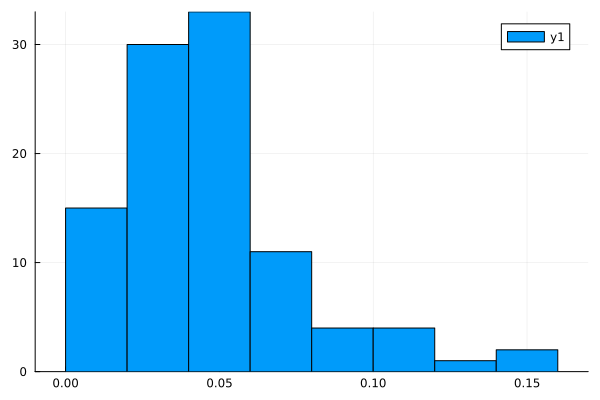

In [7]:
function compute_epsilon(emb; m=100, k=7)
    db = MatrixDatabase(emb)
    E = ExhaustiveSearch(; dist=L2Distance(), db)
    queries = rand(db, m)
    I, D = searchbatch(E, queries, k)
    histogram(last.(eachcol(D)))
end

compute_epsilon(e2)

# Clustering

In [8]:
dbscanresult = dbscan(e2, 0.02, min_cluster_size=20);

In [9]:
length(dbscanresult.clusters)

98

In [10]:
plot()

let res = KnnResult(20)
    bow = Dict{UInt32,Int32}()
    textconfig = TextConfig(group_usr=false, group_url=true, del_diac=false, del_punc=true, lc=false, group_num=true, nlist=[1], qlist=[])
    voc = filter_tokens(Vocabulary(textconfig, E.corpus.text)) do t
        5 <= t.ndocs <= 1000
    end
    
    for c in dbscanresult.clusters
        X = @view e2[1, c.core_indices]
        Y = @view e2[2, c.core_indices]
        scatter!(X, Y, c=:auto, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=1, msw=0, label="")
        if rand() < 0.3
            L = sort!(collect(countmap(E.corpus.labels[c.core_indices])), by=last, rev=true)
            L = [ "$k ($v); " for (k, v) in L]
            
            empty!(bow)
            S = []
            
            
            for i in c.core_indices
                V = bagofwords(voc, E.corpus.text[i])
                length(V) == 1 && continue  # empty vectors 
                TextSearch.add!(bow, V)
                if length(S) < 7
                    push!(S, @htl """<li>$(E.corpus.text[i])</li>""")
                end
            end
            
            res = reuse!(res)
            for (tokenID, weight) in bow
                push_item!(res, tokenID, -weight)
            end
            
            LV = []
            for p in res
                push!(LV, string(voc.token[p.id], " (", -ceil(Int, p.weight), "); "))
            end
            
            display(@htl """
            <div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
                CLUSTER LABELS ($(length(c.core_indices))): <span style="background-color: rgb(60, 60, 10);">$(L)</span>
            <div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
                VOC: $(LV)
                <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
                <ul> $S </ul>
                </div>
            </div>
            </div>
            """)
            
            # @show C[c.core_indices, :]  # cut text
        end
    end
end


<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (307): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (30); UniNoticias (23); Milenio (21); bbcmundo (20); CNNEE (20); AristeguiOnline (18); abc_es (18); NTN24 (17); el_pais (17); EFEnoticias (16); azucenau (15); TelemundoNews (14); epigmenioibarra (10); PublimetroCol (9); SinEmbargoMX (8); teleSURtv (8); Reforma (8); PublimetroChile (7); PublimetroMX (6); LaRazon_mx (5); AdriDelgadoRuiz (5); RicardoAlemanMx (5); Radio_Formula (4); abrahamendieta (2); julioastillero (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: vacunación (79); vacuna (72); vacunas (63); covid0 (40); personas (37); menores (30); vacunados (29); niños (28); vacunarse (22); dosis (22); entre (20); vacunar (19); #COVID0 (19); vacunado (17); 💉 (17); Covid0 (17); están (14); Pfizer (14); mayores (14); anticovid (14); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Esta es la lista de países a los que Estados Unidos donará vacunas anticovid https://t.co/hsB5vbWSOc</li><li>Sanidad insiste en la vacunación para mitigar la gravedad de nuevos contagios.

https://t.co/Uv0vMhXUgI https://t.co/09mb5fbT1E</li><li>El consejero de Salud y Familias, Jesús Aguirre, ha reclamado que &quot;el carné de vacunación sea obligatorio&quot; para &quot;entrar&quot; a determinados espacios públicos, como centros sanitarios, de actividades de ocio nocturno y espectáculos deportivos.

https://t.co/6eC96NCCnn</li><li>Para algunos estadounidenses, la recomendación de dejar de usar mascarilla para los completamente vacunados fue un error que ahora se paga.

https://t.co/fmj2e6k9ZC</li><li>“Es una bendición; nos ayudó mucho”: AMLO asegura en #LaMañanera que hubo presupuesto suficiente para vacunas anticovid porque no hay corrupción https://t.co/o8SLbBlwDD</li><li>#AzucenaALas10 | Anoche se registró un incendio del cuartel de la Guardia Nacional en el antiguo centro de mando de la Policía Federal; no hubo lesionados https://t.co/VZq38S4Ya4</li><li>Sin explicación alguna, un adulto mayor causó destrozos en un módulo de vacunación anticovid en Tampico, Tamaulipas
#VIDEO 
https://t.co/8MTQZpdEzK</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (34): <span style="background-color: rgb(60, 60, 10);">CNNEE (6); AristeguiOnline (5); el_pais (4); El_Universal_Mx (3); LaRazon_mx (3); UniNoticias (3); EFEnoticias (2); AdriDelgadoRuiz (2); Radio_Formula (2); SinEmbargoMX (1); Reforma (1); abc_es (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: inflación (29); precios (8); Inflación (5); 🔴 (4); plan (4); UU (4); consumidores (4); EE (4); contener (3); alto (3); BCE (3); AMLO (3); Federal (3); están (3); desde (3); te (3); bajar (3); qué (3); podría (3); Reserva (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Descarta AMLO control de precios de alimentos para contener la inflación
https://t.co/MSPEDL4AKW</li><li>La secretaria del Tesoro de EE.UU. admitió que falló en anticipar el tiempo que afectaría la alta inflación a los consumidores estadounidenses, mientras el gobierno de Biden trabaja para contener un creciente lastre político. https://t.co/ZyR78dmdcC</li><li>.@lopezobrador_ detalló que está en pláticas con productores y distribuidores de alimentos para fijar precios justos que ayuden a contener el impacto de la inflación. Los información en #FórmulaDetrásDeLaNoticia con @RicardoRocha_Mx. https://t.co/3aj9fImrLf</li><li>Si continúa la tendencia al alza en la inflación y afecta a productores, invariablemente afectará a los consumidores. 
Escucha a Rodolfo Sánchez Arriola, consultor de temas financieros
#podcast #ElDedoEnLaLLaga
#HeraldoRadio @heraldodemexico https://t.co/d1TXpySnWe</li><li>La inflación podría estar llegando a su pico y hay señales de que los precios podrían bajar pronto, según analistas. https://t.co/VrWENCW7MH</li><li>La inflación llega al 7% en EE.UU. Te contamos qué puedes esperar en los próximos meses. ¿Cómo te ha afectado la inflación en tu vida cotidiana? https://t.co/IznHS3ACeX</li><li>El plan del gobierno de AMLO para enfrentar la inflación demuestra que la administración actual sí es neoliberal, de acuerdo con Maricarmen Cortés. 
https://t.co/llREuP2z2F</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (49): <span style="background-color: rgb(60, 60, 10);">el_pais (11); abc_es (11); EFEnoticias (10); AristeguiOnline (6); NTN24 (2); PublimetroMX (2); julioastillero (2); PublimetroCol (1); epigmenioibarra (1); Milenio (1); bbcmundo (1); Reforma (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Europea (14); UE (13); Comisión (7); EU (7); Unión (6); Europa (5); millones (5); euros (4); Unido (4); Euro (4); Bruselas (4); Reino (4); #ÚLTIMAHORA (3); año (3); Gobierno (3); europeos (3); Estados (3); Francia (3); pero (3); @elpais (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Demandarán ante tribunales de EU a empresas responsables de la construcción del tramo elevado que se desplomó

https://t.co/phAJwDHQMW</li><li>RT @demiguelr: El Reino Unido amenaza a Francia con represalias por el conflicto pesquero https://t.co/NJhsgSmOJR a través de @el_pais</li><li>RT @elpais_eco: El Tribunal de Cuentas comunitario rebaja en 72.000 millones la inversión realizada por la UE para luchar contra el cambio…</li><li>Euro 2020: Inglaterra se mete en la final y pone fin al sueño de Dinamarca
https://t.co/AI8VjV79uZ https://t.co/E3aecOqp0m</li><li>Un agujero de 83.000 millones de euros al año en la UE por culpa de las falsificaciones https://t.co/UgXUUJ7ojf por @TeresaSV</li><li>Aquí está, tal cual, en la página oficial https://t.co/ZR0sdRrkgu : Comunicado del gobierno de la República al Parlamento Europeo https://t.co/qSdhFVMYQF</li><li>Cuando en Europa solo vivían 25.000 personas, pero eran muchas https://t.co/tA1ffh4kYJ Por @judithdj</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (28): <span style="background-color: rgb(60, 60, 10);">abc_es (6); El_Universal_Mx (4); CNNEE (3); Milenio (2); EFEnoticias (2); Reforma (2); AristeguiOnline (2); Radio_Formula (2); SinEmbargoMX (1); PublimetroMX (1); bbcmundo (1); LaRazon_mx (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Apple (21); iPhone (9); nuevo (6); dólares (3); millones (3); imágenes (2); todo (2); comercial (2); G (2); detalles (2); Watch (2); productos (2); comienza (2); compañía (2); fotos (2); lanzamiento (2); esto (2); vez (2); relojes (2); estos (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Apple detectará las imágenes de abuso infantil guardadas en iCloud para evitar su distribución https://t.co/Pk8HNwNmQa</li><li>RT @ReformaGadgets: En estos momentos comienza el #AppleEvent desde Cupertino, California. 

Se prevé el lanzamiento del nuevo #iPhone13 y…</li><li>Por primera vez en 6 años, #Apple es el mayor vendedor de celulares en #China 

https://t.co/B7xgLITnAo https://t.co/0DioJ9n47g</li><li>Apple podría presentar sus primeras gafas de realidad aumentada en 2022 https://t.co/y8NQFP0trO</li><li>La compañía usó tecnología de terceros en sus iPhone, iPad y Apple Watch https://t.co/zyo9pyynLe</li><li>RT @De10mx: #Entérate 😮😮 Apple da varios millones de dólares a una mujer después de que los reparadores de su iPhone publicasen sus imágene…</li><li>Y a todo esto, ¿cuánto cuesta el iPhone 13 de AMLO?
https://t.co/bL73w8ZjIP https://t.co/YWR9Mr3N2m</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (90): <span style="background-color: rgb(60, 60, 10);">CNNEE (14); PublimetroChile (7); PublimetroCol (7); Milenio (7); Radio_Formula (7); abc_es (7); EFEnoticias (6); TelemundoNews (6); El_Universal_Mx (5); LaRazon_mx (5); UniNoticias (5); PublimetroMX (4); Reforma (2); AristeguiOnline (2); NTN24 (1); SinEmbargoMX (1); julioastillero (1); el_pais (1); AdriDelgadoRuiz (1); RicardoAlemanMx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: perro (25); perros (19); mascotas (17); animales (9); 🐶 (8); tras (7); mascota (7); perrito (7); familia (7); 👇 (7); le (6); Qué (5); ser (5); sin (5); animal (5); Un (5); esta (4); mundo (4); tu (4); Así (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¿Cabras cuidando un parque? 

En #NuevaYork estos animales tienen un placentero trabajo 🐐 https://t.co/mD6V93gcrR</li><li>Cruz Roja rinde homenaje a Athos y Tango, los perritos rescatistas envenenados en Querétaro 👏 https://t.co/mx8To7CR15 https://t.co/jGAErQRNiO</li><li>Regreso a clases presenciales en Chihuahua será obligatorio: ¿Qué medidas de seguridad habrá? https://t.co/XsS5WzqzM3 https://t.co/SSAmRHBRwY</li><li>Autoridades de Colorado observan cachorros de lobo gris por primera vez en casi 80 años https://t.co/TR8DwTqOvw</li><li>¿Qué cuidados necesita un perro? Tips y consejos para su bienestar
https://t.co/CteHQsU997 https://t.co/Twn5muX9xC</li><li>RT @Vive_USA: Los perros se encontraban en terribles condiciones, sin alimento, sucios y en medio de restos de otros perros muertos. https:…</li><li>La iniciativa surge a raíz del caso de la niña que tragó un chip de perro por un anticucho en Estación Central👇
https://t.co/phNtjIDPOi</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (6); CNNEE (4); bbcmundo (3); Radio_Formula (2); AristeguiOnline (2); TelemundoNews (2); NTN24 (1); el_pais (1); SinEmbargoMX (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Corea (24); Norte (18); misiles (6); Sur (5); desde (4); misil (4); hace (4); Japón (4); Jong (4); lanzamiento (3); país (3); balísticos (3); lanzó (3); prueba (3); hacia (3); proyectil (3); Kim (3); Un (3); mar (3); nuevo (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>BTS recibe título de enviados especiales de Corea del Sur previo a su visita a la ONU
👉 https://t.co/ZhU4HSlakl https://t.co/YCSyuqY0Iu</li><li>Corea del Norte vive una de las peores crisis de su historia. Su líder, Kim Jong-un, lloró en uno de sus discursos. ¿Que está pasando en el hermético país asiático? https://t.co/eud4ZOX67r</li><li>Corea del Norte lanzó este domingo un misil balístico hacia el mar de Japón ( mar del Este en Corea), informó el Estado Mayor Conjunto surcoreano en un  comunicado en el que señala que están analizando el lanzamiento.https://t.co/6uR9Ywrdeo</li><li>👉 Corea del Norte lanzó su misil balístico de mayor alcance desde 2017. Se trata del séptimo lanzamiento en lo que va del año.

https://t.co/P4Jzwo5H8R</li><li>Esta acción coordinada entre EU y Corea del Sur se produce un día después de que Corea del Norte disparara un número idéntico de misiles balísticos de corto alcance. https://t.co/MVuQne1RrW</li><li>Corea del Norte: los menores que trabajan como &quot;voluntarios&quot; en las minas https://t.co/apzpZfSdg9</li><li>Corea del Norte prueba misiles balísticos lanzados desde vagones
https://t.co/aFRL7LJTbU</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (101): <span style="background-color: rgb(60, 60, 10);">AristeguiOnline (11); El_Universal_Mx (9); Milenio (9); abc_es (9); TelemundoNews (7); RicardoAlemanMx (6); Radio_Formula (6); UniNoticias (6); SinEmbargoMX (5); LaRazon_mx (5); teleSURtv (5); epigmenioibarra (3); bbcmundo (3); EFEnoticias (3); Reforma (3); el_pais (3); PublimetroMX (2); PublimetroChile (2); julioastillero (1); CNNEE (1); azucenau (1); AdriDelgadoRuiz (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: gasolina (26); gas (25); precio (23); LP (22); precios (18); Gas (13); petróleo (12); combustible (11); aumento (8); Bienestar (8); 👉 (7); está (6); mil (6); barril (6); demanda (5); euros (5); ⛽ (5); crudo (5); #Video (5); litro (5); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Precio del gas LP: Conoce los costos del combustible en México para la semana del 26 de junio al 2 de julio.     https://t.co/r5xdkVf1Hc</li><li>El precio del gas LP ha aumentado en un año casi 30 %, lo que ha resultado en un mayor gasto para los consumidores y en ganancias para las empresas, en especial para las nueve que controlan el mercado en México, de acuerdo con datos de la CRE y la Profeco https://t.co/oa0OeXyGo5 https://t.co/zmevRdKlyn</li><li>El precio del petróleo #Brent alcanzó el precio de 108.44 dólares por barril,  siendo la cifra más alta del crudo registrada desde agosto del año 2014 https://t.co/oPK9RY0eIJ</li><li>Este es el precio de la gasolina en CDMX.
https://t.co/fPsh5WTpaZ</li><li>El ministro de Comercio de #Haití 🇭🇹 desmintió un alza en los precios de combustibles, luego que las estaciones de gasolina experimentaran una alta demanda a causa del rumor https://t.co/EiO3QNEfzd</li><li>El acuerdo alcanzado entre Gobierno y transportistas de mercancías por carretera rebaja el precio del carburante en 20 céntimos por litro y promete aplicar al sector los principios de la ley de la cadena alimentaria.

https://t.co/kQjeYrLHMI</li><li>Estos son los precios del gas LP del 24 al 30 de abril | Lista completa
https://t.co/YVWbbnpXE7</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (35): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (7); Radio_Formula (6); Milenio (3); NTN24 (2); SinEmbargoMX (2); PublimetroMX (2); Reforma (2); el_pais (2); UniNoticias (2); TelemundoNews (2); PublimetroCol (1); bbcmundo (1); EFEnoticias (1); AristeguiOnline (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: lluvias (14); inundaciones (11); agua (6); desbordamiento (5); Las (5); río (5); ▶ (4); zonas (4); 🚨 (4); fuertes (3); Edomex (3); tormenta (3); daños (3); hombre (3); Ecatepec (3); #VIDEO (3); lluvia (3); @ElUniversalOax (3); #Entérate (3); nuevas (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¡Atención! Nueva emergencia por creciente súbita de río en Mocoa https://t.co/uOxLWV4v9i https://t.co/PBvbp7kiuW</li><li>RT @NTN24ve: Torrenciales lluvias ocurridas este martes provocaron el desbordamiento del río Urama en el estado Carabobo, dejando al munici…</li><li>RT @ElUniversalOax: #Entérate ⚠️ El gobernador Alejandro Murat (@alejandromurat) informó que debido a los daños provocados por las lluvias…</li><li>Las fuertes lluvias ocasionaron daños en el municipio de Macuspana.

https://t.co/ySuYOF2FdN</li><li>RT @AlbertEltiempo: ⚠️ ¡ATENCIÓN!

13 millones están bajo una vigilancia por inundacion repentinas entre Georgia, las Carolinas, Virginia y…</li><li>#ENVIVO | En #Chihuahua, bombardearán nubes para provocar lluvias y terminar la sequía 
 
Edson Calderón tiene el reporte
 
Síguelo por @mileniotv 
https://t.co/0sluB57Acz</li><li>#ENVIVO | Se reportan severas lluvias en #Nayarit debido a la llegada del huracán #Pamela, piden tomar precauciones

Salvador Arellano tiene el reporte

Síguelo en @mileniotv  
 
https://t.co/6j6keU88dA</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (25): <span style="background-color: rgb(60, 60, 10);">abc_es (9); EFEnoticias (4); bbcmundo (2); el_pais (2); PublimetroMX (2); UniNoticias (2); El_Universal_Mx (1); SinEmbargoMX (1); teleSURtv (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: vivienda (7); precio (6); alquiler (5); hipotecas (5); inmobiliario (5); viviendas (4); hasta (4); también (3); Informa (3); interés (2); ciudades (2); año (2); nuevo (2); Las (2); banca (2); agosto (2); según (2); trimestre (2); tipos (2); pero (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>¿Dónde se busca más comprar viviendas en las capitales de la región? ¿La pandemia cambió las históricas preferencias?  https://t.co/w260gGXMgD</li><li>La morosidad de las hipotecas concedidas por la banca a los hogares bajó en marzo por tercer trimestre consecutivo, hasta el 3,19 %, igual que los impagos de la financiación al sector inmobiliario, que mejoraron hasta el 4,83 %.

https://t.co/HSB70P5OZt</li><li>Caos en el cobro del alquiler tras la entrada en vigor del límite del 2% https://t.co/LZaxNjRUY0 Informa @ggines</li><li>#ENVIVO🔴| #VladímirPutin: Considero que se puede bajar el interés de las hipotecas hasta un 7% →https://t.co/tqMKHfl0b4 https://t.co/1lPpThVNWL</li><li>Las hipotecas se disparan por el nuevo &apos;boom&apos; imobiliario y el mínimo histórico de los tipos de interés https://t.co/iqVwDQhGB2</li><li>El precio de la vivienda en alquiler en la costa ha repuntado un 2,8 % en lo que va de año hasta los 751 euros, mientras que el precio de venta ha crecido un 0,9 % con respecto a 2020, según el portal inmobiliario https://t.co/ZvLQeRYQCE.

https://t.co/qcfhEs0qW0</li><li>#LoMásLeído Los jóvenes que no trabajen también podrán acceder al bono del alquiler https://t.co/Yu3ZPzTdmw</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (30): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (12); El_Universal_Mx (3); AdriDelgadoRuiz (3); AristeguiOnline (3); RicardoAlemanMx (2); Reforma (2); Milenio (2); EFEnoticias (1); PublimetroMX (1); Radio_Formula (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Pemex (35); empresa (13); cambiaron (11); saquearon (11); #JuicioAExPresidentes (11); Pero (11); hicieron (11); petrolera (11); intentaron (11); sigue (11); importación (11); quebrar (11); abandonaron (11); refinerías (11); riqueza (11); fortunas (11); gasolinas (11); yacimientos (11); huachicoleo (11); privatizar (11); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Pemex tomará hoy control de la refinería Deer Park en Texas, aseguran fuentes 

https://t.co/Oyz7CmFV3e https://t.co/hcxbwNbcVX</li><li>“Hoy el negocio de @Pemex no es la estación de servicio, aunque lo que quiere es instalar la #marca, el 43% de su negocio está en la venta, comercialización, almacenamiento y reparto de #gasolina y diésel” #RamsésPech experto en #industriaeléctrica
#ElDedoEnLaLLaga #HeraldoRadio</li><li>Pemex
Por décadas saquearon la riqueza petrolera, intentaron quebrar a la empresa, cambiaron la ley para privatizar los yacimientos, abandonaron las refinerías, hicieron fortunas con la importación de gasolinas y con el huachicoleo... Pero Pemex sigue en pie
#JuicioAExPresidentes https://t.co/duOGryOJCD</li><li>Pemex
Por décadas saquearon la riqueza petrolera, intentaron quebrar a la empresa, cambiaron la ley para privatizar los yacimientos, abandonaron las refinerías, hicieron fortunas con la importación de gasolinas y con el huachicoleo... Pero Pemex sigue en pie
#JuicioAExPresidentes https://t.co/pPiLHqtW4Q</li><li>Pemex
Por décadas saquearon la riqueza petrolera, intentaron quebrar a la empresa, cambiaron la ley para privatizar los yacimientos, abandonaron las refinerías, hicieron fortunas con la importación de gasolinas y con el huachicoleo... Pero Pemex sigue en pie
#JuicioAExPresidentes https://t.co/uVwRnC174J</li><li>Entre los analistas, el consenso general es que la única salida para mejorar el balance financiero de@Pemex es una #reformafiscal
Lee y escucha la columna “Pemex: La encrucijada”
#podcast #ElDedoEnLaLlaga #OpinionesCompletas
#HeraldoRadio @heraldodemexico #Pemex https://t.co/b9RsNLTkln</li><li>Pemex
Por décadas saquearon la riqueza petrolera, intentaron quebrar a la empresa, cambiaron la ley para privatizar los yacimientos, abandonaron las refinerías, hicieron fortunas con la importación de gasolinas y con el huachicoleo... Pero Pemex sigue en pie
#JuicioAExPresidentes https://t.co/v83Etvmd6Y</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (68): <span style="background-color: rgb(60, 60, 10);">bbcmundo (17); EFEnoticias (12); abc_es (10); el_pais (8); CNNEE (7); teleSURtv (4); PublimetroChile (2); AristeguiOnline (2); NTN24 (1); SinEmbargoMX (1); El_Universal_Mx (1); PublimetroCol (1); RicardoAlemanMx (1); UniNoticias (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: talibanes (44); Afganistán (28); Kabul (11); país (9); talibán (9); poder (8); mujeres (7); Talibán (7); tras (6); grupo (6); está (5); desde (5); control (5); manos (4); pero (4); capital (4); después (4); periodista (4); provincia (4); #Afganistán (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>La desesperación se agrava en los lugares donde se concentran las decenas de miles de personas desplazadas, que llegaron a Kabul huyendo de los talibanes desde ciudades como Herat o Kunduz y que ahora se han visto atrapadas otra vez https://t.co/KsBdpnhEz8</li><li>#EFEFotos | Los talibanes decretan el uso obligatorio del burka en lugares públicos. https://t.co/aBSaKh2sRQ</li><li>Giorgio Buccellati: «Al Daesh, como a los talibanes, hay que combatirlos con las ideas y la arqueología es útil» https://t.co/y9U7LqZ3AX Por @arrizabalaga11</li><li>Tras concretar la caída de Afganistán en manos de los insurgentes, corren rumores de una nueva era para este país, en el que ya habrían iniciado los asesinatos por venganza y la radio local fue rebautizada como “Voz de la Sharía”
https://t.co/ESTiD1r8ke https://t.co/tw1Mdxwk87</li><li>Los talibanes ya detentaron el poder entre 1996 y 2001, tras una guerra civil que dejó el país reducido a escombros. Entonces, esos extremistas suníes implantaron un régimen basado en su interpretación de la ley islámica, la &apos;sharía&apos; https://t.co/5Xj9L2KlCM</li><li>Los momentos claves de la crisis de Afganistán, una semana después. Un recorrido en vídeo por los momentos más destacados de los últimos siete días, tras la entrada de los talibanes en Kabul https://t.co/uL0JLjdoHC https://t.co/F7qpuzSn5y</li><li>Los talibanes agradecen la ayuda y piden rebajar la presión sobre Afganistán.

https://t.co/p1OS1pp9gz https://t.co/geAKXbYq3X</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (105): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (24); el_pais (20); CNNEE (19); abc_es (16); teleSURtv (8); bbcmundo (6); NTN24 (3); Radio_Formula (3); El_Universal_Mx (2); UniNoticias (2); PublimetroCol (1); LaRazon_mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: volcán (66); Palma (54); erupción (25); lava (17); Vieja (15); 🔴 (15); Cumbre (15); 📡 (13); Erupción (13); #ENDIRECTO (13); información (12); Toda (11); Efeservicios (11); DIRECTO (9); volcánica (9); mar (8); tras (7); TV (7); coladas (7); está (6); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Las primeras fotografías de Nuku’alofa, capital de Tonga, desde la erupción del volcán muestran una ciudad con muchas edificaciones reducidas a escombros y cubierta de ceniza https://t.co/sjL7tYrP28</li><li>Aventurero en La Palma toma la foto de su vida del volcán: erupción, mar de nubes y la vía láctea

https://t.co/VECMg8Mmyr</li><li>🔴📡 #ENDIRECTO | Erupción volcánica en la Cumbre Vieja de La Palma https://t.co/OV06Z5G7V4</li><li>🔴📡 #ENDIRECTO | Erupción volcánica en la Cumbre Vieja de La Palma

Toda la información en Efeservicios: https://t.co/cQkG6tHbOI https://t.co/bPTWsLs0Ho</li><li>🔵 #DIRECTO El volcán entra en &apos;zona de estabilidad&apos;, con coladas más lentas, cuatro bocas activas y solo una fisura https://t.co/aSlNC3ytOD https://t.co/HUSgg8nGqP</li><li>RT @elpais_foto: #FotodePortada del martes en @el_pais https://t.co/ibl8tQy6wz La lava arrasa todo a su paso y eleva el riesgo de gases tóx…</li><li>RT @NTN24ve: Dióxido de azufre del volcán La Palma no afectará directamente a Venezuela https://t.co/oAxRF6xxQ8</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (55): <span style="background-color: rgb(60, 60, 10);">CNNEE (11); EFEnoticias (8); UniNoticias (6); el_pais (5); abc_es (5); AristeguiOnline (4); El_Universal_Mx (3); bbcmundo (2); teleSURtv (2); Radio_Formula (2); TelemundoNews (2); SinEmbargoMX (1); PublimetroMX (1); LaRazon_mx (1); Reforma (1); RicardoAlemanMx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: aborto (42); derecho (14); Corte (11); ley (11); Suprema (10); Estados (6); semanas (6); despenalización (6); Texas (6); proyecto (5); tras (5); decisión (5); embarazo (5); abortos (5); Unidos (5); #ÚLTIMAHORA (4); De (4); Las (4); interrupción (4); después (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>ANÁLISIS: Después de anular el derecho federal al aborto y flexibilizar las leyes de armas, la mayoría conservadora de la corte construida por el expresidente Donald Trump limitó la capacidad del gobierno para luchar contra el cambio climático
https://t.co/l6Nort1X5V</li><li>#Estados | Las colectivas hicieron un llamado para que la despenalización del aborto deje ser un tema utilizado mediáticamente y por intereses políticos.

Por @Il_Contreras | #PublimetroPuebla 

https://t.co/MaUnvnBqcq</li><li>Las pastillas abortivas, la nueva trinchera en EE.UU. tras la sentencia del Supremo https://t.co/2rAWusvrhE Por @jansorena, corresponsal en Washington</li><li>Las búsquedas en internet de pastillas para aborto se disparan https://t.co/Q0mmu4s1rk</li><li>#ÚLTIMAHORA | Constitucional de Colombia despenaliza el aborto libre hasta las 24 semanas. https://t.co/mTbzGPUluy</li><li>RT @elpais_america: 🔴 De confirmarse el fin de ‘Roe vs. Wade’, Nueva York se convertiría en el Estado más cercano donde poder abortar para…</li><li>California, Washington y Oregon crean compromiso para defender derecho al aborto https://t.co/weknR5Zlty https://t.co/YCzqAQVGJd</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (55): <span style="background-color: rgb(60, 60, 10);">CNNEE (11); AristeguiOnline (9); PublimetroMX (7); PublimetroCol (3); LaRazon_mx (3); el_pais (3); Radio_Formula (3); abc_es (3); PublimetroChile (2); El_Universal_Mx (2); bbcmundo (2); teleSURtv (2); EFEnoticias (2); NTN24 (1); SinEmbargoMX (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Messi (50); Lionel (19); PSG (13); _MX (7); @Publisport (7); Barcelona (6); Video (5); @deportescnn (5); ante (4); mundo (4); Leo (4); ⚽ (4); _espanol (4); tras (3); esta (3); Barça (3); dos (3); Cristiano (3); le (3); eso (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @Publisport_MX: #Messi se pronuncia por primera vez tras recuperarse del covid-19 
https://t.co/L7BUrTSvun</li><li>#ÚltimoMinuto 🚨 | Lionel Messi confirma su partida del @FCBarcelona https://t.co/ZMTszSWdbd</li><li>La compañía de Gerard Piqué adquirió los derechos por tres años para la emisión de los partidos que Messi juegue en la Ligue 1.

https://t.co/TeLmUu64xA</li><li>RT @Publisport_MX: Min 25 ¡UUUUUUUY.... AUTOGOL DEL @AFCAjax!

Sébastien Haller la mete en propia puerta y se empata el marcador 

@SLBenfi…</li><li>RT @laaficion: La salida de Messi dispara la búsqueda de objetos coleccionables un 1200% https://t.co/Dv7wYwLIUt https://t.co/dF7Ld9KKBj</li><li>🧵| 🐐𝑳𝒊𝒐𝒏𝒆𝒍 𝑴𝒆𝒔𝒔𝒊🔟 no pudo contener las lágrimas cuando la selección ofreció a la afición la reciente #CopaAmérica conseguida

𝑴𝒆𝒔𝒔𝒊 mencionó que hace mucho que soñaba con lograr este nuevo récord https://t.co/sfSJxcz56J</li><li>La felicitación más esperada era la de su eterno equipo, el FC Barcelona. Así le celebraron el cumpleaños número 35 a Messi.

https://t.co/mO60R8AfFI</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (5); Milenio (3); RicardoAlemanMx (3); abrahamendieta (2); azucenau (2); Radio_Formula (2); julioastillero (1); epigmenioibarra (1); bbcmundo (1); LaRazon_mx (1); el_pais (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: médicos (21); cubanos (11); contratación (7); _ (3); son (3); mil (3); López (3); o (3); países (3); #AzucenaALas0 (3); 🎙 (2); doctora (2); donde (2); especialistas (2); ese (2); asociaciones (2); Obrador (2); Que (2); IMSS (2); plazas (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🚢 #EnVivo en #AstilleroInforma

Como legislan, investigan. El tema de Julen Rementería es penoso. Los médicos cubanos que vinieron a apoyar forman parte del contingente Henry Reeve. Han prestado sus servicios en más de 22 países: @juanbaaq  
https://t.co/5AVghcNojf https://t.co/asI6PdLNKo</li><li>🚨 #ÚLTIMAHORA |  &apos;Congelan&apos; a médicos cubanos: juez admite amparo contra contratación https://t.co/GYZ3cLVYnT https://t.co/Yec78rJY8U</li><li>#AzucenaALas10 | Hospitales de la montaña de Guerrero representan un reto para aquellos médicos, nacionales o cubanos, que sean asignados en alguno de ellos: la falta de equipo, medicamentos e insumos https://t.co/vXU4dZtTX4</li><li>Los médicos son personas morales; su moralidad no debe ser infringida por los intereses de los pacientes o de la comunidad médica #Opinión de Arnoldo Kraus https://t.co/HNudi8kNtR</li><li>▶️ &quot;Que nos desmientan&quot;

El subsecretario de Salud, Hugo López-Gattel, retó a instituciones de medicina a enviar listado de médicos que se necesitan para cubrir plazas en zonas marginadas

📺 La historia con @azucenau 
#AzucenaALas10 https://t.co/Pt6C5Shka1</li><li>#SinRodeos | La pasada contratación de médicos cubanos fue absolutamente ilegal porque no se acreditó que ese personal hubiera homologado sus títulos y obtenido su cédula profesional en México para trabajar aquí 🎙La columna de @DiegoFC

https://t.co/IIIMEFvQVz https://t.co/6iMJRFUytP</li><li>RT @Planeta_Futuro: Sobre cuidados paliativos: la capacidad para responder a los temores de los pacientes es importante, se demostró con du…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">bbcmundo (5); El_Universal_Mx (5); CNNEE (3); AristeguiOnline (3); abc_es (2); julioastillero (2); NTN24 (1); el_pais (1); LaRazon_mx (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Musk (21); Elon (18); Twitter (14); quiere (4); social (4); No (3); red (3); le (3); extremo (3); dice (2); tras (2); género (2); tener (2); 🚢 (2); mi (2); está (2); cambiar (2); @De0 (2); pero (2); 😯 (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Elon Musk le dice a la BBC que él nunca quiso ser director ejecutivo de Apple pero admite que en un momento pensó venderle Tesla a la compañía de la manzanita https://t.co/9aVpWmWRGg</li><li>El padre de Twitter bendice la llegada de Elon Musk mientras Bezos trolea al nuevo dueño https://t.co/QN6I5Hfoe2</li><li>Twitter: qué puede cambiar en la red social tras la compra de Elon Musk (y las dudas que genera) https://t.co/1tOKhsHsEj</li><li>Junta directiva de Twitter avala acuerdo con Musk y recomienda a los accionistas votar a favor

https://t.co/IJ1cQJlZqx</li><li>Elon Musk dice que quiere que Twitter alcance su &quot;extraordinario potencial&quot;. https://t.co/1vqrgUAOJ0</li><li>RT @De10mx: #Famosos 😯😯 Según Amber Heard lo que la unió a Elon Musk fue la “curiosidad intelectual, ideas, conversación y un amor comparti…</li><li>🔴 Musk, sobre su oferta por sorpresa para comprar Twitter por 43.000 millones: “No prosperará ni cumplirá con este imperativo social en su forma actual. Es mi mejor y última propuesta. Si no se acepta, tendría que reconsiderar mi posición como accionista” https://t.co/XMlOjDeqrq</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (50): <span style="background-color: rgb(60, 60, 10);">CNNEE (12); UniNoticias (7); TelemundoNews (6); NTN24 (4); Milenio (3); abc_es (3); El_Universal_Mx (2); bbcmundo (2); EFEnoticias (2); el_pais (2); AristeguiOnline (2); SinEmbargoMX (1); PublimetroMX (1); PublimetroChile (1); LaRazon_mx (1); Reforma (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Biden (52); Joe (24); presidente (19); año (7); Estados (6); primer (6); Unidos (6); 🎥 (4); presidencia (4); le (4); discurso (4); UU (4); EE (4); tras (3); vivo (3); martes (3); Trump (3); si (3); 👉 (3); Más (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Joe Biden cumple un año en la Presidencia de Estados Unidos y este miércoles hará un balance sobre su gestión https://t.co/CXyaotioAD https://t.co/umHyY5bJeX</li><li>🇺🇸Estos son los temas de los que Biden hablará en su primer discurso en las Nacionales Unidas.

https://t.co/zNMouqx04B</li><li>El presidente de EE.UU., Joe Biden, subió el martes a su escenario más importante del año en medio del tramo más importante de su presidencia hasta el momento. Si te lo perdiste, aquí hay 5 conclusiones del primer discurso del estado de la Unión de Biden. https://t.co/mgdai0QSOO</li><li>RT @Vive_USA: El presidente Biden calificó de &quot;basura&quot; las informaciones de que su Gobierno planeaba pagar 450 mil dólares por persona como…</li><li>Biden dice estar &quot;desconsolado&quot; por la muerte de Desmond Tutu https://t.co/CRqneKsYfO</li><li>🎥 ¿Cuáles son los logros que resalta el presidente Biden de su primer año de mandato?

https://t.co/vK2825y1b4</li><li>Biden hizo polémica en Washington al decirle “estúpido hijo de p***” a un reportero ante un micrófono abierto

https://t.co/QGJE7PoZzB</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (60): <span style="background-color: rgb(60, 60, 10);">PublimetroChile (10); PublimetroCol (10); Reforma (6); El_Universal_Mx (5); CNNEE (5); NTN24 (4); SinEmbargoMX (3); Milenio (3); Radio_Formula (3); abc_es (3); bbcmundo (2); el_pais (2); julioastillero (1); LaRazon_mx (1); EFEnoticias (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Netflix (49); serie (10); 👇 (9); película (8); #Netflix (8); ver (8); producciones (6); Amazon (6); te (6); temporada (6); todo (5); dejamos (5); Te (5); cinco (5); plataforma (5); + (5); puedes (5); éxito (4); estreno (4); son (4); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#Dune: 6 #Oscar
#CODA: 3

Estos son el resto de ganadores en una noche que vuelve a decir que no a Netflix:
https://t.co/HJqQhp9w5y</li><li>Netas&amp;amp;Chill | Nicanor propone ver la película &quot;La Cabeza de la Araña&quot;, en #Netflix, un thriller basada en un cuento corto que se lee en 10 minutos, pero que los escritores estiraron para convertirla en película... y se nota. @DrNetas https://t.co/Ysv57Ke0uU</li><li>RT @Univ_espect: Hoy en nuestra #AlfombraRoja:
-A Luis Estrada Eficine lo rechaza, pero Netflix lo contrata 😎
-Río Roma se pone nervioso 😬…</li><li>RT @reformagente: #EnPortada. ¡Historias que inspiran! #Netflix celebrará la lucha libre femenil en una serie. #EntérateEnGente de los deta…</li><li>Netflix: estos son todos los ESTRENOS para enero de 2022.
https://t.co/SQJtCVfiY5 https://t.co/WaUqKjAJ1u</li><li>CRÓNICA | Con la aspiración de conquistar a los amantes del género fantástico y convertirse en una saga de culto, se estrena en Amazon Prime Video “La rueda del tiempo”, una serie inspirada en un universo de fantasía.

Por Paula Escalada 
https://t.co/ghryMnIPRi</li><li>En el día de su cumpleaños, te dejamos cinco producciones de Zendaya que puedes ver en Netflix, Amazon, HBO Max y Disney+.

https://t.co/BX4TyqJnJA</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (22): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (7); CNNEE (5); el_pais (4); Reforma (1); PublimetroMX (1); PublimetroChile (1); abc_es (1); bbcmundo (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: príncipe (11); Isabel (10); II (9); Harry (9); reina (8); @Revista (6); _Clase (6); Carlos (4); hijo (4); Gales (3); Meghan (3); está (3); Príncipe (3); ustedes (3); trono (3); William (3); tras (2); títulos (2); mundo (2); Markle (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>William y Harry se reencuentran para honrar la memoria de su madre, la difunta Lady Di | Video https://t.co/73LAYS7MkF https://t.co/VC0K59Ko0x</li><li>RT @demamasdepapas: ¿Un príncipe caprichoso o un niño normal? Los expertos analizan la conducta del príncipe Luis de Cambridge durante el J…</li><li>RT @Revista_Clase: El príncipe Harry vuelve a la controversia: asegura que él está a cargo de la seguridad de la reina Isabel II 
#royals #…</li><li>Enrique y Meghan han anunciado el nacimiento de su hija, que será la octava en la línea de sucesión al trono. Su nombre es un homenaje a la reina Isabel II y a su abuela, Diana de Gales https://t.co/AXEXUXQIIN</li><li>La reina Isabel II pidió que cuando su hijo Carlos se convierta en rey, su esposa, la duquesa de Cornualles, sea conocida como reina Camilla. ¿Qué opinas? https://t.co/o16rBMBuQp</li><li>RT @Revista_Clase: El príncipe William, el favorito para seguir con el legado de la reina Isabel II 
#FelizCumpleaños @KensingtonRoyal #Hap…</li><li>Una fuente cercana dijo a CNN que la reina Isabel II se reunió &quot;recientemente&quot; con el príncipe Carlos antes de dar positivo en covid-19.  https://t.co/AqHDWibzVO</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (22): <span style="background-color: rgb(60, 60, 10);">PublimetroMX (4); el_pais (4); EFEnoticias (3); abc_es (3); AristeguiOnline (3); CNNEE (2); NTN24 (1); El_Universal_Mx (1); Milenio (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Madrid (8); Real (6); Liga (5); _MX (4); 🔥 (4); @Publisport (4); League (4); Champions (4); City (3); UEFA (3); final (3); Barcelona (3); tras (2); Liverpool (2); Atlético (2); afición (2); Europa (2); está (2); vez (2); @EFEdeportes (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>El Real Madrid comparte la copa con la afición, en imágenes https://t.co/yRojVin0AV</li><li>Termina la segunda etapa de Dani Alves con Barcelona | Vídeo
 https://t.co/r0qIJzq7JQ https://t.co/UEzDWXURMB</li><li>RT @Publisport_MX: #UCLFinal | ¡SE TERMINÓ! ¡EL REAL MADRID ES CAMPEÓN! 

El Real Madrid conquista su título número 14 de la Champions Leag…</li><li>RT @laaficion: Problemas en el Stade de France

#UCLfinal se retrasa por incidentes con afición del Liverpool

VIDEO ▶ https://t.co/DhjOrhf…</li><li>Eintracht Frankfurt sorprendió a Barcelona en un dramático partido de vuelta para llegar a las semifinales de la Europa League.  https://t.co/5l1lucZajg</li><li>RT @EFEdeportes: City, PSG, Tottenham, F1, MotoGP, el Mundial de fútbol. Y ahora, el LIV Invitational, que con 2.000 millones ha roto el go…</li><li>🔵#ACTUALIZACIÓN Eriksen está despierto y estable, según su agente. La UEFA confirma que el encuentro se reanudará a las 20.30 horas https://t.co/NNVCpjnk5o</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (99): <span style="background-color: rgb(60, 60, 10);">teleSURtv (18); bbcmundo (10); EFEnoticias (9); NTN24 (7); abrahamendieta (6); RicardoAlemanMx (6); abc_es (6); CNNEE (5); TelemundoNews (5); UniNoticias (4); PublimetroChile (3); Milenio (3); AdriDelgadoRuiz (3); PublimetroMX (2); El_Universal_Mx (2); el_pais (2); AristeguiOnline (2); Radio_Formula (2); PublimetroCol (1); julioastillero (1); azucenau (1); Reforma (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: Cuba (51); 🇺 (23); #Cuba (19); 🇨 (19); régimen (13); cubanos (12); cubano (12); isla (12); país (11); protestas (10); gobierno (10); Canel (8); le (8); libertad (8); Díaz (8); cubana (7); Miguel (7); fin (6); dictadura (6); está (6); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Detenida una mujer por matar a martillazos a un amigo en Bétera https://t.co/sKEe3rP7ik</li><li>#EnVideo | Pueblo cubano sale a las calles de la #Habana para expresar su apoyo al Gobierno de Miguel @DiazCanelB ante las recientes provocaciones y campañas de desprestigio https://t.co/PEVp1R4rei</li><li>Cuba alzará su voz nuevamente en contra del régimen de Díaz-Canel en unas protestas previstas para el 15 de noviembre. ¿Qué necesita cambiar cuanto antes en la isla? Activistas responden. https://t.co/jfa6Tqn69A</li><li>RT @DANIELTUYUB: @RicardoAlemanMx Apoyando a Cuba</li><li>En una rueda de prensa, con participación también de organizaciones de exiliados de Nicaragua, Venezuela y Siria, el exilio reiteró su respaldo a la &quot;rebelión popular&quot; desatada en Cuba y a la convocatoria de un &quot;paro nacional&quot; para hacer caer al régimen. https://t.co/8g3P6mXHe9</li><li>El mensaje de Álvaro Uribe a la “resistencia cubana” https://t.co/cTuz52UJpk https://t.co/jURd9lJBti</li><li>Protestas en Cuba: cómo vivió la isla “el día después” de las mayores manifestaciones en más de medio siglo https://t.co/k1ySr3bMkX</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (34): <span style="background-color: rgb(60, 60, 10);">Milenio (13); Radio_Formula (5); PublimetroChile (2); PublimetroCol (2); Reforma (2); el_pais (2); AdriDelgadoRuiz (2); SinEmbargoMX (1); bbcmundo (1); LaRazon_mx (1); CNNEE (1); EFEnoticias (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: mejor (14); Ahora (11); deporte (11); mundo (10); Lo (10); deportivo (8); @laaficion (8); Mantente (6); @mileniotv (6); deportes (6); informado (5); está (3); Ya (2); _ (2); @rsangerman (2); 🎙 (2); tu (2); entre (2); deportiva (2); No (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Ahora | Lo mejor de los deportes está en @laaficion

Mantente informado en @mileniotv https://t.co/eplgczzCVO</li><li>Ahora | La mejor información deportiva en @laaficion

Mantente al día en @mileniotv

https://t.co/83zHpJkYQ7</li><li>Según la PFA fue nominado tras “la mejor temporada goleadora de su carrera”.👇
https://t.co/zAZv6UMRAS</li><li>.@rsangerman ya está #Alaire con lo mejor de los deportes. El @Dedoenlallaga_ por #ElHeraldoRadio de @heraldodemexico.</li><li>Opinión | &quot;Por encima de cualquier medalla o marca obtenida en la competición, al margen de todo registro para la posteridad del deporte, los lazos con otros países y el impacto en sus gentes es el verdadero privilegio de los juegos&quot;. Por Carla Suárez https://t.co/DIzaLSy0EC</li><li>“Somos merecedores de segundas oportunidades”, estableció el gerente deportivo de Azul...👇
 https://t.co/4UOOBuaPYC</li><li>El deporte recuperó su esencia a lo largo de un 2021 lleno de dramatismo
 https://t.co/Jtlt0V5vOc https://t.co/dGLsJ2pZ63</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (32): <span style="background-color: rgb(60, 60, 10);">julioastillero (8); AdriDelgadoRuiz (8); abc_es (4); CNNEE (3); bbcmundo (2); NTN24 (1); SinEmbargoMX (1); PublimetroMX (1); El_Universal_Mx (1); Reforma (1); el_pais (1); Radio_Formula (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: variante (14); ómicron (6); Ómicron (5); nueva (4); Europa (3); 🔴 (3); podría (3); ya (3); 👍 (2); Totalmente (2); detecta (2); Covid (2); acuerdo (2); casos (2); 👊 (1); estudios (1); conocen (1); aseguró (1); #ÚLTIMAHORA (1); evidente (1); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Mil gracias</li><li>RT @NTN24ve: La investigadora del Instituto Venezolano de Investigaciones Científicas, Flor Pujol, aseguró que la variante Mu del covid cir…</li><li>🔴 La OMS nombra Omicron a la nueva variante y advierte de un posible «mayor riesgo de reinfección» https://t.co/WKJ7glB3Qu</li><li>Listo</li><li>😊👍 Gracias</li><li>RT @doctormacias: Covid: Confirma Holanda que la variante Ómicron estaba ya presente antes de lo que se pensaba en el país. Es evidente que…</li><li>Saber si será la variante más peligrosa de todas es la principal incógnita alrededor de ómicron. 

https://t.co/jRYV5huS0X</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (23): <span style="background-color: rgb(60, 60, 10);">UniNoticias (7); CNNEE (4); bbcmundo (3); NTN24 (1); SinEmbargoMX (1); PublimetroMX (1); PublimetroChile (1); El_Universal_Mx (1); Milenio (1); Radio_Formula (1); abc_es (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: calor (17); temperaturas (12); ola (6); o (5); grados (5); @AlbertEltiempo (4); ➡ (4); fin (3); Las (3); Qué (3); semana (3); hasta (3); podría (3); Se (2); Canadá (2); excesivo (2); donde (2); noroeste (2); Te (2); récord (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>🎥 ¿Cuánto podría durar la ola de calor excesivo en California? Esto pronostica Albert Martínez, meteorólogo de Univision.

https://t.co/KOZ28SQZq0</li><li>RT @AlbertEltiempo: Mirad esto.

Las temperaturas en la costa oeste vuelven a subir hasta los 115º en Portland o 110º en Seattle.

Estos va…</li><li>El agotamiento por calor y el golpe de calor son dos de las varias condiciones que tú o alguien alrededor tuyo puede sufrir. Aquí te explicamos cómo se diferencian. https://t.co/M95GI84vTp</li><li>☀️ Un peligroso calor excesivo azotará al sur de EE.UU. Se registrarán temperaturas de tres dígitos. 

https://t.co/kQJPQBc1OI</li><li>➡️  Hay advertencia por tiempo invernal para Wisconsin y Minnesota y viento intenso en las Dakotas.  

➡️   Pronostican temperaturas alrededor de los 80 grados para Los Ángeles el fin de semana. 

Informa @AlbertEltiempo https://t.co/nLhJdywqAU</li><li>Una ola de calor en el noreste de EE.UU. romperá decenas de récords este fin de semana

https://t.co/HAPX4tZaWw</li><li>Cómo una &quot;mancha caliente&quot; cerca de Nueva Zelanda está contribuyendo a la megasequía en Sudamérica.

https://t.co/5uevccsoxo</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (33): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (26); julioastillero (3); PublimetroMX (1); Radio_Formula (1); AdriDelgadoRuiz (1); teleSURtv (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: al0 (13); Meses (9); #PaseDeLista0 (8); #Ayotzinapa0 (8); @epigmenioibarra (8); PM (7); @Drago0 (7); #PaseDeListaDel0 (6); @roberthm0 (3); @ANGELICASALAZA0 (3); @Lubruixa (3); @alynmon (3); FM (3); @juanbaaq (3); 📻 (3); _0 (3); @ethally0 (3); @julioastillero (2); _irm (2); _ (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @ANGELICASALAZA7: Comenzamos #PaseDeLista1al43x43</li><li>RT @ANGELICASALAZA7: #Presente 🙋✋ #PaseDeLista1al43x43</li><li>RT @juanbaaq: #PaseDeLista1al43</li><li>RT @ANGELICASALAZA7: Hasta el próximo #PaseDeLista1al43</li><li>RT @TlacatecolotlMX: #InMemoriam 
#AldoGutierrezSolano 
#Presente 
#Ayotzinapa89Meses</li><li>RT @delaCruzChung: @ups tiene en estatus de salida mi paquete 1Z32453 X04114 14685 desde inicio de febrero.
No encuentran y me preguntan si…</li><li>RT @JosGarc86445673: Apoyo a do Epigmenio.</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (86): <span style="background-color: rgb(60, 60, 10);">El_Universal_Mx (67); abrahamendieta (3); LaRazon_mx (3); Milenio (3); Reforma (2); julioastillero (2); AdriDelgadoRuiz (2); epigmenioibarra (2); PublimetroMX (1); AristeguiOnline (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: @ElUniversalOax (65); Oaxaca (64); #Oaxaca (18); #Entérate (17); x (10); Hidalgo (9); 🚩 (9); Istmo (7); 🤩 (5); 🏽 (5); #EnVideo (5); ✅ (5); Roo (4); mil (4); 👉 (4); dar (4); Salud (4); comunidades (4); 🚨 (4); Juárez (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @ElUniversalOax: ⚠️ Hasta 400 desplazados dejan ataques en comunidades de Atatlahuca, en la Mixteca de Oaxaca ⬇️  https://t.co/sgLTZIQSbY</li><li>RT @ElUniversalOax: 😭¿Pensabas este año ir a la #Guelaguetza? Te tenemos malas noticias: Confirman que Oaxaca se queda sin su máxima fiesta…</li><li>Este será parte del legado de @alejandromurat en #Oaxaca 👇👇https://t.co/CBX4XhRv1u</li><li>RT @ElUniversalOax: 🚩 Extrabajadores de Salud exigen recontratación inmediata y aguinaldo 2021; bloquean aeropuerto de Oaxaca

https://t.co…</li><li>Censarán a más de 26 mil familias en comunidades de Oaxaca con daños por Agatha

https://t.co/oypzuMsfis https://t.co/YgTEKbXZ1s</li><li>RT @ElUniversalOax: #EnVideo Con sede en la Plaza de la Danza, en la Ciudad de #Oaxaca se realiza el segundo día de la Feria del Emprendimi…</li><li>RT @ElUniversalOax: 👉🏽 Exrector de la UABJO exige a AMLO y al gobierno de Oaxaca respeto a autonomía universitaria  📍

https://t.co/ndo6NAj…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (40): <span style="background-color: rgb(60, 60, 10);">EFEnoticias (8); bbcmundo (5); UniNoticias (5); El_Universal_Mx (4); teleSURtv (4); Reforma (2); el_pais (2); abc_es (2); NTN24 (1); PublimetroMX (1); Milenio (1); CNNEE (1); azucenau (1); RicardoAlemanMx (1); Radio_Formula (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: casos (18); muertes (11); mil (7); personas (7); millones (7); semana (7); nuevos (7); covid0 (6); han (6); muerte (5); desde (5); muertos (5); total (5); año (4); contagios (4); cifra (4); causa (4); Un (4); informó (4); últimas (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Un total de 172 personas han recibido ayuda para morir en el primer año de la ley, pero no en todas las comunidades autónomas dan las mismas facilidades. En este artículo contamos tres casos de eutanasia con tres finales de vida muy distintos: de una de... https://t.co/hYGBZWL51t</li><li>RT @materia_ciencia: Los problemas derivados del sedentarismo son responsables de más de cinco millones de muertos al año y suponen 46.000…</li><li>🚨 #ÚLTIMAHORA | COVID anda ‘bravo’: suman 16,214 nuevos casos y 23 fallecidos adicionales.
https://t.co/yn5OBTCwMk https://t.co/x22XbGLXJQ</li><li>Los casos globales de covid suben tras 2 meses a la baja pero las muertes caen un 21%.

https://t.co/ZROtIADOtv https://t.co/0sGTuguFRx</li><li>La transmisión del covid ha bajado 42 puntos desde el viernes y se sitúa en 549 casos, aunque sigue sin reflejarse en la presión asistencial, que continúa en ascenso: hay 2.032 enfermos en las ucis (103 más que el viernes)

https://t.co/zqA490adx0</li><li>Advierten: La desigualdad mata. Un informe de @oxfam_es señala que la desigualdad mata a una persona cada cuatro segundos. Estos son otros datos contundentes. https://t.co/wI1JQj366O</li><li>Un total de 2.520 nuevos contagios y siete fallecidos más por COVID se han registrado en las últimas 24 horas en Cataluña, donde además ha aumentado el riesgo de rebrote y el número de pacientes ingresados en las unidades de cuidados intensivos (UCI).

https://t.co/jghE1YS7qc</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (26): <span style="background-color: rgb(60, 60, 10);">CNNEE (5); el_pais (4); bbcmundo (4); Reforma (3); EFEnoticias (2); El_Universal_Mx (2); AristeguiOnline (2); TelemundoNews (2); NTN24 (1); teleSURtv (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: criptomonedas (12); bitcoin (8); Salvador (5); Bitcoin (5); moneda (5); euros (4); país (4); mundo (4); primer (4); esta (3); hace (3); cada (3); millones (3); cuatro (2); ante (2); año (2); invertir (2); seis (2); Estados (2); sea (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>#Economía Bitcoin alcanzó $ 60.126 antes de la cotización de la mayor criptobolsa de EE. UU. https://t.co/zRuzFd2RUb</li><li>Caen los precios de las criptomonedas  después de que Rusia lanzara un ataque militar contra Ucrania; más de 150,000 mdd se retiran del mercado

https://t.co/MRGrWtyJFx</li><li>Estas son las ventajas y desventajas de invertir en criptomonedas 👉 https://t.co/M3haUZzmBy</li><li>Las criptomonedas vuelven a repuntar apenas una semana después de que las afectara una gran venta masiva. ¿Cuánto subió cada una? https://t.co/Y6XLJDhEoW</li><li>El mundo de las criptomonedas se dio cita en Miami Beach para la conferencia Bitcoin 2022, un cónclave de cuatro días que permitirá hacer negocios, informarse de las novedades, escuchar a expertos y acelerar la implantación del token digital más conocido.
https://t.co/95Pb9kboRO https://t.co/pxCAflY8Hu</li><li>El bitcoin se ha desplomado un 35%, el Ethereum un 44%...Otras, como Terra USD, han perdido más del 80%. La exuberancia con la que crecía este jardín invitaba a la purga. ¿Cuántas de estas criptomonedas sobrevivirán? ¿Ha habido un crecimiento desmedido? https://t.co/UYmOtG9cuh</li><li>La minería mundial de Bitcoin consume al año una cantidad equiparable a la de toda Suecia @dw_espanol #DW_español https://t.co/HaCuVdRrgE</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (63): <span style="background-color: rgb(60, 60, 10);">epigmenioibarra (44); El_Universal_Mx (4); julioastillero (3); abrahamendieta (2); el_pais (2); SinEmbargoMX (1); CNNEE (1); LaRazon_mx (1); azucenau (1); teleSURtv (1); Reforma (1); RicardoAlemanMx (1); abc_es (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: #0 (31); @LupitaRivera0 (26); Terquita (17); hoy (17); Te (16); Memoria (15); Ejercicio (15); Terquito (15); #PaseDeLista0 (15); al0 (15); invito (14); De (14); Colectiva (14); Únete (13); @epigmenioibarra (13); pm (12); Hoy (11); Al (10); tenemos (10); Están (9); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @mablomeli: Hoy a las 21:30 horas estaré en el programa &quot;El palo de la piñata&quot; con Sol Hernández ( el sitio de @julioastillero ) habland…</li><li>RT @qennin53: Mi hija y mi esposa se encuentran en Mazatlán, Sinaloa, sus credenciales del INE son del Edo. de Quintana Roo, y no las dejan…</li><li>RT @LupitaRivera453: @epigmenioibarra #14Marzo 

¡Únete Terquita terquito!

Ejercicio De Memoria Colectiva 

Te invito hoy 9:00 al legendar…</li><li>RT @epigmenioibarra: Mañana miércoles a las 8:00 estaré, nuevamente, con @CiroGomezL en @Radio_Formula. Las diferencias, en tanto nos quede…</li><li>No te pierdas el #ForoMascotasREFORMA el próximo martes 20 de julio, a las 11:00 horas.

#ForosREFORMA #DíaMundialdelPerro 🐶 🐱

Cuando viajas:</li><li>El día de mañana está programa la audiencia de #EmmaCoronel, esposa de Joaquín #ElChapo Guzmán 

Todos los detalles con @vhmichel en #AzucenaxFórmula</li><li>RT @ortega_santoyo: Vengan todos juntos en punto de las 21.00 PM Al #Legendario #PaseDeLista1Al43 de nuestro terco y necio compañero 
@epig…</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (31): <span style="background-color: rgb(60, 60, 10);">julioastillero (12); RicardoAlemanMx (4); AdriDelgadoRuiz (3); El_Universal_Mx (2); el_pais (2); AristeguiOnline (2); PublimetroMX (1); abrahamendieta (1); azucenau (1); teleSURtv (1); EFEnoticias (1); Reforma (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: periodistas (14); periodista (7); @julioastillero (6); AMLO (5); prensa (3); Gracias (3); Periodistas (3); _ (2); @arnoldocuellaro (2); #ElDedoEnLaLlaga (2); 🚢 (2); mi (2); poder (2); hay (2); presidente (2); A (2); están (2); Y (2); No (2); son (2); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>RT @NotasSinPauta: El mejor análisis está en la mesa de periodistas de los martes con @DanyBarraganG, @julioastillero, @arnoldocuellaro y @…</li><li>RT @DeTodos_Modos: 🗞️😎 @julioastillero es un periodista que mezcla el oficio periodístico con la pasión por la política 👊🏾

¡Esta noche @Jo…</li><li>RT @alexmelon: Importantísimo escuchar esta clase de periodismo de @arnoldocuellaro de @poplabmx en el espacio de @julioastillero para ente…</li><li>RT @RicardoAlemanMx: #EnLaSemana | A ver si así respetan: Periodistas abandonan conferencia de prensa de Morena
https://t.co/pgQIjEqFIJ</li><li>.@lumendoz: “Sí hay un daño moral importante, soy periodista, soy madre de casa y los periodistas vivimos de nuestra credibilidad”.</li><li>&quot;Cada frase lapidaria, amenazante, injuriosa hacia los periodistas puede poner en riesgo a estos periodistas que están en estas zonas tan conflictivas&quot; señala @jpbecerraacosta sobre las palabras del presidente contra la prensa #ConLosDeCasa 

▶️https://t.co/31KBXgBHCY https://t.co/kYGS16YMFf</li><li>Periodismo, Aristegui, AMLO: viernes de preguntas y respuestas. https://t.co/a9k5ziUC4S vía @YouTube</li> </ul>
    </div>
</div>
</div>

<div style="margin: 0.5em; padding: 0.5em; background-color: rgb(120, 120, 10);">
    CLUSTER LABELS (36): <span style="background-color: rgb(60, 60, 10);">PublimetroMX (5); NTN24 (4); PublimetroCol (4); teleSURtv (4); Milenio (3); CNNEE (3); PublimetroChile (2); El_Universal_Mx (2); EFEnoticias (2); bbcmundo (1); AdriDelgadoRuiz (1); AristeguiOnline (1); RicardoAlemanMx (1); Radio_Formula (1); abc_es (1); TelemundoNews (1); </span>
<div style="margin: 2em; padding: 0.5em; background-color: rgb(100, 200, 60);">
    VOC: casos (24); mil (13); millones (9); contagios (7); covid0 (6); nuevos (6); Covid0 (6); país (5); esta (4); #Covid0 (4); donde (3); mundo (3); continente (3); reporte (3); personas (3); han (3); registraron (3); solo (3); variante (3); muertes (3); 
    <div style="background-color: rgb(100, 100, 60);">EXEMPLARS:
    <ul> <li>Autoridades sanitarias reportaron 20 mil 079 infecciones más el viernes, que suman 1 millón 16 mil 944.
https://t.co/cw9OFhBqG1</li><li>RT @ElUniversal_SLP: #ÚltimaHora 🚨 Se han acumulado 104 mil 970 casos y seis mil 935 muertes por Covid-19 desde que inició la pandemia en S…</li><li>Las señales de alerta se han disparado debido al rápido aumento de casos detectados en Sudáfrica con esta variante. 

https://t.co/sr5D5aothp</li><li>RT @ADNOpinion: “Comparativamente con otros sismos de esta misma intensidad, en cualquier país del mundo se hubiera multiplicado por muchos…</li><li>Aunque la variante ómicron ha sido identificada en al menos 19 estados del país, es delta la que más daño continúa haciendo. 

En la última semana el promedio diario de contagios ascendió a 119,000 casos mientras diariamente se están reportando 1,300 fallecidos. https://t.co/qEILGcSNrF</li><li>Confirman al menos 176 casos de covid-19 asociados a conciertos de Bad Bunny https://t.co/Tg5x1gu3jD</li><li>La @opsoms comunicó que la pandemia de la Covid-19 fue mucho más severa en 2021 en el continente americano, registrándose el triple de fallecimientos que en 2020, para un total de 2.3 millones de decesos https://t.co/9teMFUA3JO</li> </ul>
    </div>
</div>
</div>

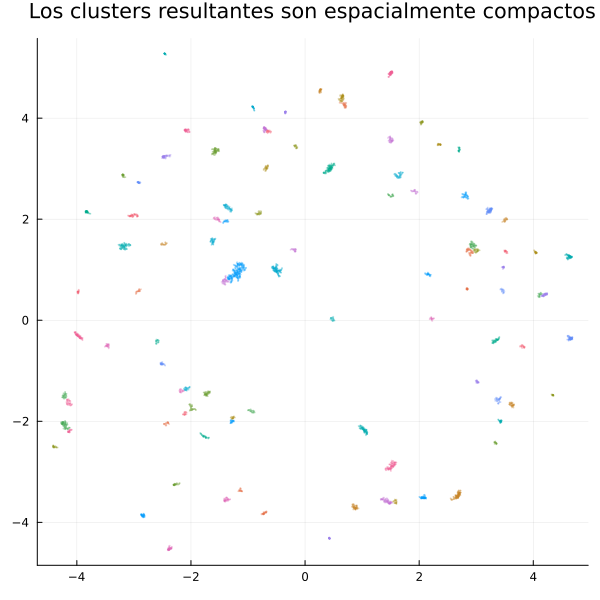

In [12]:
plot!(title="Los clusters resultantes son espacialmente compactos")


# Actividades
- Si usa Julia, revise el paquete `SimilaritySearch.jl`: <https://github.com/sadit/SimilaritySearch.jl> y <https://github.com/sadit/SimSearchManifoldLearning.jl>.
- Si usa Python, revise el paquete UMAP: <https://umap-learn.readthedocs.io/en/latest/>.
- Qué ventajas y desventajas tiene usar este método vs. otros métodos de clustering como $k$-means.
- Prepare la colección de `wikipedia` de español con la representación semántica de SBERT, adicionalmente reproduzcalo para la representación basada en bolsa de palabras (primeras unidades del curso). Puede usar una muestra más pequeña si usar el dataset completo no es una opción viable. Reproducir las operaciones y el análisis de este notebook con estos datos.

# Bibliografía

- [@AW2019] Amid, E., & Warmuth, M. K. (2019). TriMap: Large-scale dimensionality reduction using triplets. arXiv preprint arXiv:1910.00204.
- [@LV2017] Lee, J. A., & Verleysen, M. (2007). Nonlinear dimensionality reduction (Vol. 1). New York: Springer.
- [@MHM2018] McInnes, L., Healy, J., & Melville, J. (2018). Umap: Uniform manifold approximation and projection for dimension reduction. arXiv preprint arXiv:1802.03426.
- [VSPU2017] Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017). Attention is all you need. Advances in neural information processing systems, 30.
- [RG2020] Reimers, N., & Gurevych, I. (2020). Making monolingual sentence embeddings multilingual using knowledge distillation. arXiv preprint arXiv:2004.09813.
- [@SKL2011] Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, E. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- [@SPA2019] Soto, A. J., Przybyła, P., & Ananiadou, S. (2019). Thalia: semantic search engine for biomedical abstracts. Bioinformatics, 35(10), 1799-1801.
- [@SS2021] Sharma, K. K., & Seal, A. (2021). Spectral embedded generalized mean based k-nearest neighbors clustering with S-distance. Expert Systems with Applications, 169, 114326.
- [@VMH2018] Van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(11).
- [@YCC2020] Yu, Q., Chen, K. H., & Chen, J. J. (2020, September). Using a set of triangle inequalities to accelerate k-means clustering. In International Conference on Similarity Search and Applications (pp. 297-311). Springer, Cham.